# Modeling

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
path = os.path.join("FINAL_no_TR.xlsx")

# Read the Excel file
FINAL_no_TR = pd.read_excel(path)

# Display the first few rows
FINAL_no_TR.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82


### What are the most important programming hubs?

To answer this first research question about identifying the most important programming hubs by NUTS3 region, we need to establish criteria that define what constitutes a "high programming activity" area. Here are some considerations and steps to approach this:

**Weighted Stack Overflow Metrics:** Since questions, answers, and comments on Stack Overflow are direct indicators of programming activity, they should be weighted more heavily than upvotes and downvotes. You might consider a weighted sum where questions, answers, and comments have higher weights.

**Activity Thresholds:** Establish minimum thresholds for these metrics to filter out regions with very low programming activity. This could be based on either absolute numbers or relative to the population of the region.

**Growth Over Time:** Consider the growth rate of these activities over the period from 2008 to 2020. Regions with a significant increase in activity might be more relevant than those with stagnant or declining rates.

**Economic Resilience:** Consider the economic indicators like GDP, GVA and employment.

We could use the following weights:

**Questions (40%):** Posting questions is a primary indicator of active problem-solving and learning in the programming community. It shows a need for knowledge and a willingness to seek assistance, which is fundamental in a vibrant and growing programming hub. A high volume of questions suggests a significant level of engagement in programming activities.

**Answers (40%):** Providing answers is equally crucial, as it demonstrates expertise and a community's capacity to support its members. A region with a high number of answers indicates not only active participation but also a certain level of proficiency and knowledge-sharing culture in the programming community.

**Comments (10%):** Comments, while important for clarifying questions and answers, are generally less indicative of programming activity than the questions and answers themselves. They contribute to the community engagement and collaborative problem-solving process but are a secondary activity compared to asking and answering questions.

**Upvotes (5%) and Downvotes (5%):** Upvotes and downvotes are indicators of community engagement and the quality of content being produced. However, they are more passive forms of participation compared to asking questions, providing answers, or commenting. Therefore, they are assigned a lower weight. They do, however, play a role in indicating the relevance and usefulness of the content, which is why they are included in the weighting scheme.

In [3]:
# Assign weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

FINAL_no_TR['activity'] = (FINAL_no_TR['questioncount']*weights['questions'] + 
                          FINAL_no_TR['answercount']*weights['answers'] + 
                          FINAL_no_TR['commentcount']*weights['comments'] + 
                          FINAL_no_TR['upvotecount']*weights['upvotes'] + 
                          FINAL_no_TR['downvotecount']*weights['downvotes'])

In [4]:
top_regions = FINAL_no_TR.groupby('nuts3_name')['activity'].sum().sort_values(ascending=False).head(10)
print(top_regions)

nuts3_name
Paris                     936830.30
Stockholm County          601726.20
Zürich                    490853.45
Madrid                    424617.05
Barcelona                 383257.60
Milan                     281899.75
Rome                      237735.70
Västra Götaland County    236363.85
Skåne County              235994.55
Hauts-de-Seine            222983.05
Name: activity, dtype: float64


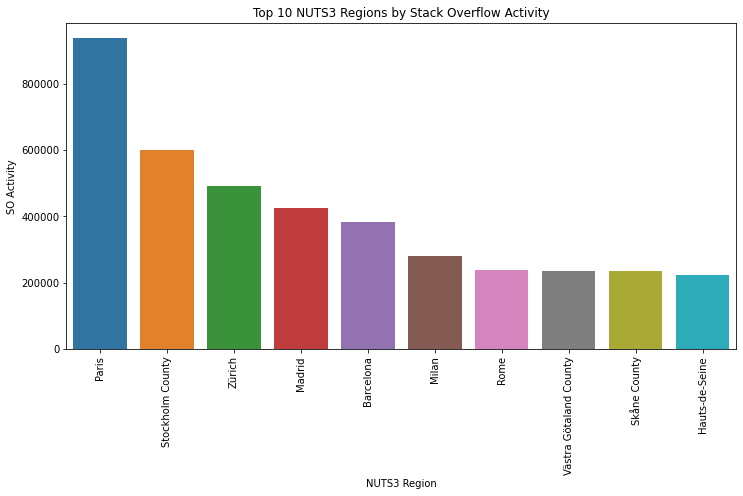

In [5]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions.index, y=top_regions.values)
plt.title('Top {} NUTS3 Regions by Stack Overflow Activity'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('SO Activity')
plt.xticks(rotation=90)
plt.show()

We can observe:

- Capital regions or regions with a lot of population tend to have a lot of programming activity (all the capitals of the countries in our dataset are represented in the Top 10)
- The broader area of Paris (Paris + Hauts-de-Seine) has a lot of programming activity (almost double the activity of the second biggest region), which could be due to its high population

**Standardization:**

It would make sense to standardize the SO activity data across regions, allowing for more accurate comparisons. Without adjusting for population size, regions with larger populations might naturally appear to have higher programming activity simply due to more people being present, not necessarily higher engagement per person.

In [6]:
# Create columns for programming activity per capita
for i in range(3,8):
    column_name = FINAL_no_TR.columns[i]
    FINAL_no_TR[column_name + ' per cap'] = FINAL_no_TR[column_name] / (FINAL_no_TR['POP (THS)'] * 1000)

In [7]:
FINAL_no_TR['activity per cap'] = (FINAL_no_TR['questioncount per cap']*weights['questions'] + 
                          FINAL_no_TR['answercount per cap']*weights['answers'] + 
                          FINAL_no_TR['commentcount per cap']*weights['comments'] + 
                          FINAL_no_TR['upvotecount per cap']*weights['upvotes'] + 
                          FINAL_no_TR['downvotecount per cap']*weights['downvotes'])

top_regions_str = FINAL_no_TR.groupby('nuts3_name')['activity per cap'].sum().sort_values(ascending=False).head(10)
top_regions_str

nuts3_name
Balearic Islands    0.923772
Paris               0.426897
Zürich              0.334160
La Palma            0.303449
Zug                 0.284383
Stockholm County    0.271339
Basel-Stadt         0.271222
Genève              0.230338
Vaud                0.198039
Skåne County        0.181360
Name: activity per cap, dtype: float64

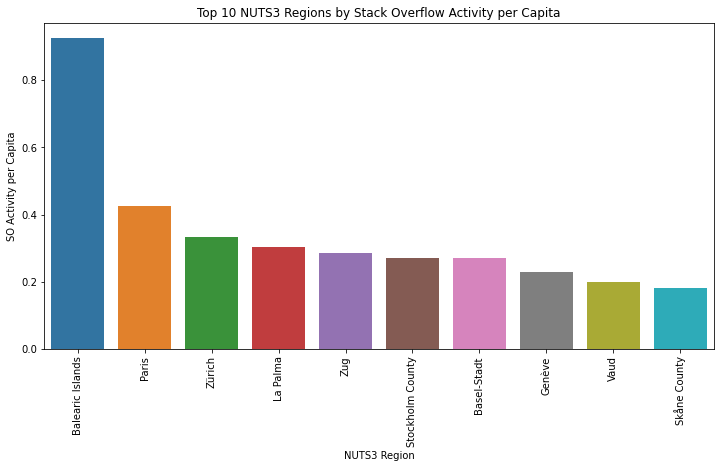

In [8]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_str.index, y=top_regions_str.values)
plt.title('Top {} NUTS3 Regions by Stack Overflow Activity per Capita'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('SO Activity per Capita')
plt.xticks(rotation=90)
plt.show()

We can see that the Top 10 regions change if you standardize the programming activity by dividing it by population. 

We can observe:

- Switzerland has a lot of important programming hubs with Zürich, Zug, Basel-Statd, Genève and Vaud.
- The Balearic Islands and La Palma seem to be very important hubs, which can be connected to their increasing popularity for digital nomads and remote workforce.
- The Balearic Islands seem to be a super-hub with more than double the activity than the second biggest region

There probably is a relation between population and programming activity. It is important to note that the identified hubs with standardization aren't more or less relevant than the ones without. 

In terms of importance, many developers in one area could mean that there is more exchange happening on a local level, such as developer courses, conferences and fairs. Additionally, we have to consider that metropoles offer a much bigger range of employment opportunites due to the industry landscape.

**Including growth of programming activity:**

So far, we only looked at the programming activity in the overall time period from 2008 until 2020. We could also consider the growth of programming activity as a metric for the importance of a programming hub.

For this we are going to compute the Compound Annual Growth Rate (CAGR).

**Formula:** $$CAGR = \left( \frac{\text{Ending Value}}{\text{Beginning Value}} \right)^{\frac{1}{\text{Number of Years}}} - 1$$



In [11]:
# Function to calculate the CAGR
def calculate_cagr(end_value, start_value, num_years):
    if start_value == 0:  # To avoid division by zero
        return None
    return (end_value/start_value)**(1/num_years) - 1

# Apply to all the NUTS3 regions
for region in FINAL_no_TR['nuts3_name'].unique():
    # Get the data for the region
    region_data = FINAL_no_TR[FINAL_no_TR.nuts3_name == region]
    
    # Calculate CAGR
    start_value = region_data[region_data.year == 2008]['activity per cap'].values[0]
    end_value = region_data[region_data.year == 2020]['activity per cap'].values[0]
    num_years = 12
    cagr = calculate_cagr(end_value, start_value, num_years)
    
    # Update DataFrame
    FINAL_no_TR.loc[FINAL_no_TR.nuts3_name == region, 'CAGR'] = cagr
    
FINAL_no_TR

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,GVA (MIO_EUR),POP (THS),activity,questioncount per cap,answercount per cap,upvotecount per cap,downvotecount per cap,commentcount per cap,activity per cap,CAGR
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,23931.324019,586.60,104.40,0.000147,0.000285,0.000000,0.000000,0.000055,0.000178,0.365857
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,24614.963819,595.84,1613.75,0.000621,0.003845,0.006978,0.000445,0.005508,0.002708,0.365857
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,27311.621095,604.17,3692.10,0.002744,0.006741,0.020858,0.000785,0.012346,0.006111,0.365857
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,31336.257699,614.88,5460.90,0.003051,0.009821,0.026688,0.003841,0.022058,0.008881,0.365857
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,32261.320850,622.82,7074.50,0.005180,0.010051,0.039178,0.006703,0.029724,0.011359,0.365857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,...,16305.800000,449.00,5501.70,0.010049,0.007009,0.040225,0.003526,0.032425,0.012253,0.285921
3948,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,...,16657.120000,454.99,4762.65,0.007985,0.007172,0.035682,0.003310,0.024554,0.010468,0.285921
3949,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,...,16710.180000,460.01,4976.75,0.008006,0.005469,0.042860,0.004076,0.030817,0.010819,0.285921
3950,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,...,16714.730000,464.00,3978.85,0.006373,0.004390,0.043039,0.002679,0.019841,0.008575,0.285921


Now we can visualize the top regions in terms of growth:

In [14]:
top_regions_CAGR = FINAL_no_TR.groupby('nuts3_name')['CAGR'].mean().sort_values(ascending=False).head(10)
print(top_regions_CAGR)

nuts3_name
Ardèche          1.061376
Messina          0.848218
Ancona           0.826690
Ascoli Piceno    0.815805
Naples           0.809821
Catania          0.801730
Lecce            0.793183
Lucca            0.787814
Pas-de-Calais    0.751031
Pescara          0.749062
Name: CAGR, dtype: float64


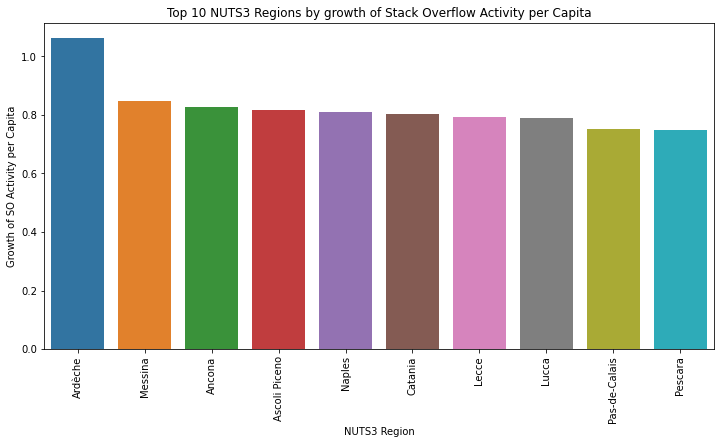

In [15]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_CAGR.index, y=top_regions_CAGR.values)
plt.title('Top {} NUTS3 Regions by growth of Stack Overflow Activity per Capita'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Growth of SO Activity per Capita')
plt.xticks(rotation=90)
plt.show()

We can observe that 9/10 of the regions with highest average growth in SO activity are from Italy.

### Linear Regression - Which variables will best predict high programming density “in town”?